### !pip install git+https://github.com/Cupcakus/pafy
!pip install --upgrade youtube-dl

In [1]:
!pip3 install fiftyone
!pip3 install ipywidgets

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached fiftyone-0.14.3-py3-none-any.whl (1.2 MB)
  Using cached mongoengine-0.20.0-py3-none-any.whl (106 kB)
  Using cached kaleido-0.2.1-py2.py3-none-macosx_11_0_arm64.whl (85.8 MB)
  Using cached Pillow-9.0.1-1-cp39-cp39-macosx_11_0_arm64.whl (2.7 MB)
  Using cached pprintpp-0.4.0-py2.py3-none-any.whl (16 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Using cached pymongo-3.12.3.tar.gz (821 kB)
  Preparing metadata (setup.py) ... done
  Using cached scikit-image-0.19.1.tar.gz (22.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached universal_analytics_python3-1.1.1-py3-none-a

In [2]:
import cv2 # opencv2 package for python.
import numpy as np
import fiftyone.zoo as foz

import fiftyone as fo

In [3]:
import torch
from torch import hub
import torchvision
from time import time

In [45]:
from PIL import Image
from torchvision.transforms import functional as func
from fiftyone import ViewField as F

In [56]:
import os

In [5]:
yolo5 = torch.hub.load( \
                      'ultralytics/yolov5', \
                      'yolov5s', \
                      pretrained=True)


Using cache found in /Users/macos/.cache/torch/hub/ultralytics_yolov5_master


YOLOv5 🚀 2022-1-20 torch 1.10.1 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [82]:
def prepend_path(img, path):
    return path+str(img)

In [83]:
path = '/Users/macos/fiftyone/coco-2017/validation/data/'
imgs = os.listdir(path)
imgs = [prepend_path(image, path) for image in imgs]
imgs

['/Users/macos/fiftyone/coco-2017/validation/data/000000011051.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000006471.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000005193.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000008844.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000002006.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000001296.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000006894.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000009769.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000007977.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000001490.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000026204.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000009378.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000007816.jpg',
 '/Users/macos/fiftyone/coco-2017/validation/data/000000001532.jpg',
 '/Users/macos/fiftyone/coco-2017/

In [6]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person", "car", "truck", "traffic light"],
    max_samples=100,
)

Found annotations at '/Users/macos/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 100/100 [393.5ms elapsed, 0s remaining, 254.7 samples/s]      
Dataset 'coco-2017-validation-100' created


In [7]:
dataset

Name:        coco-2017-validation-100
Media type:  image
Num samples: 100
Persistent:  False
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


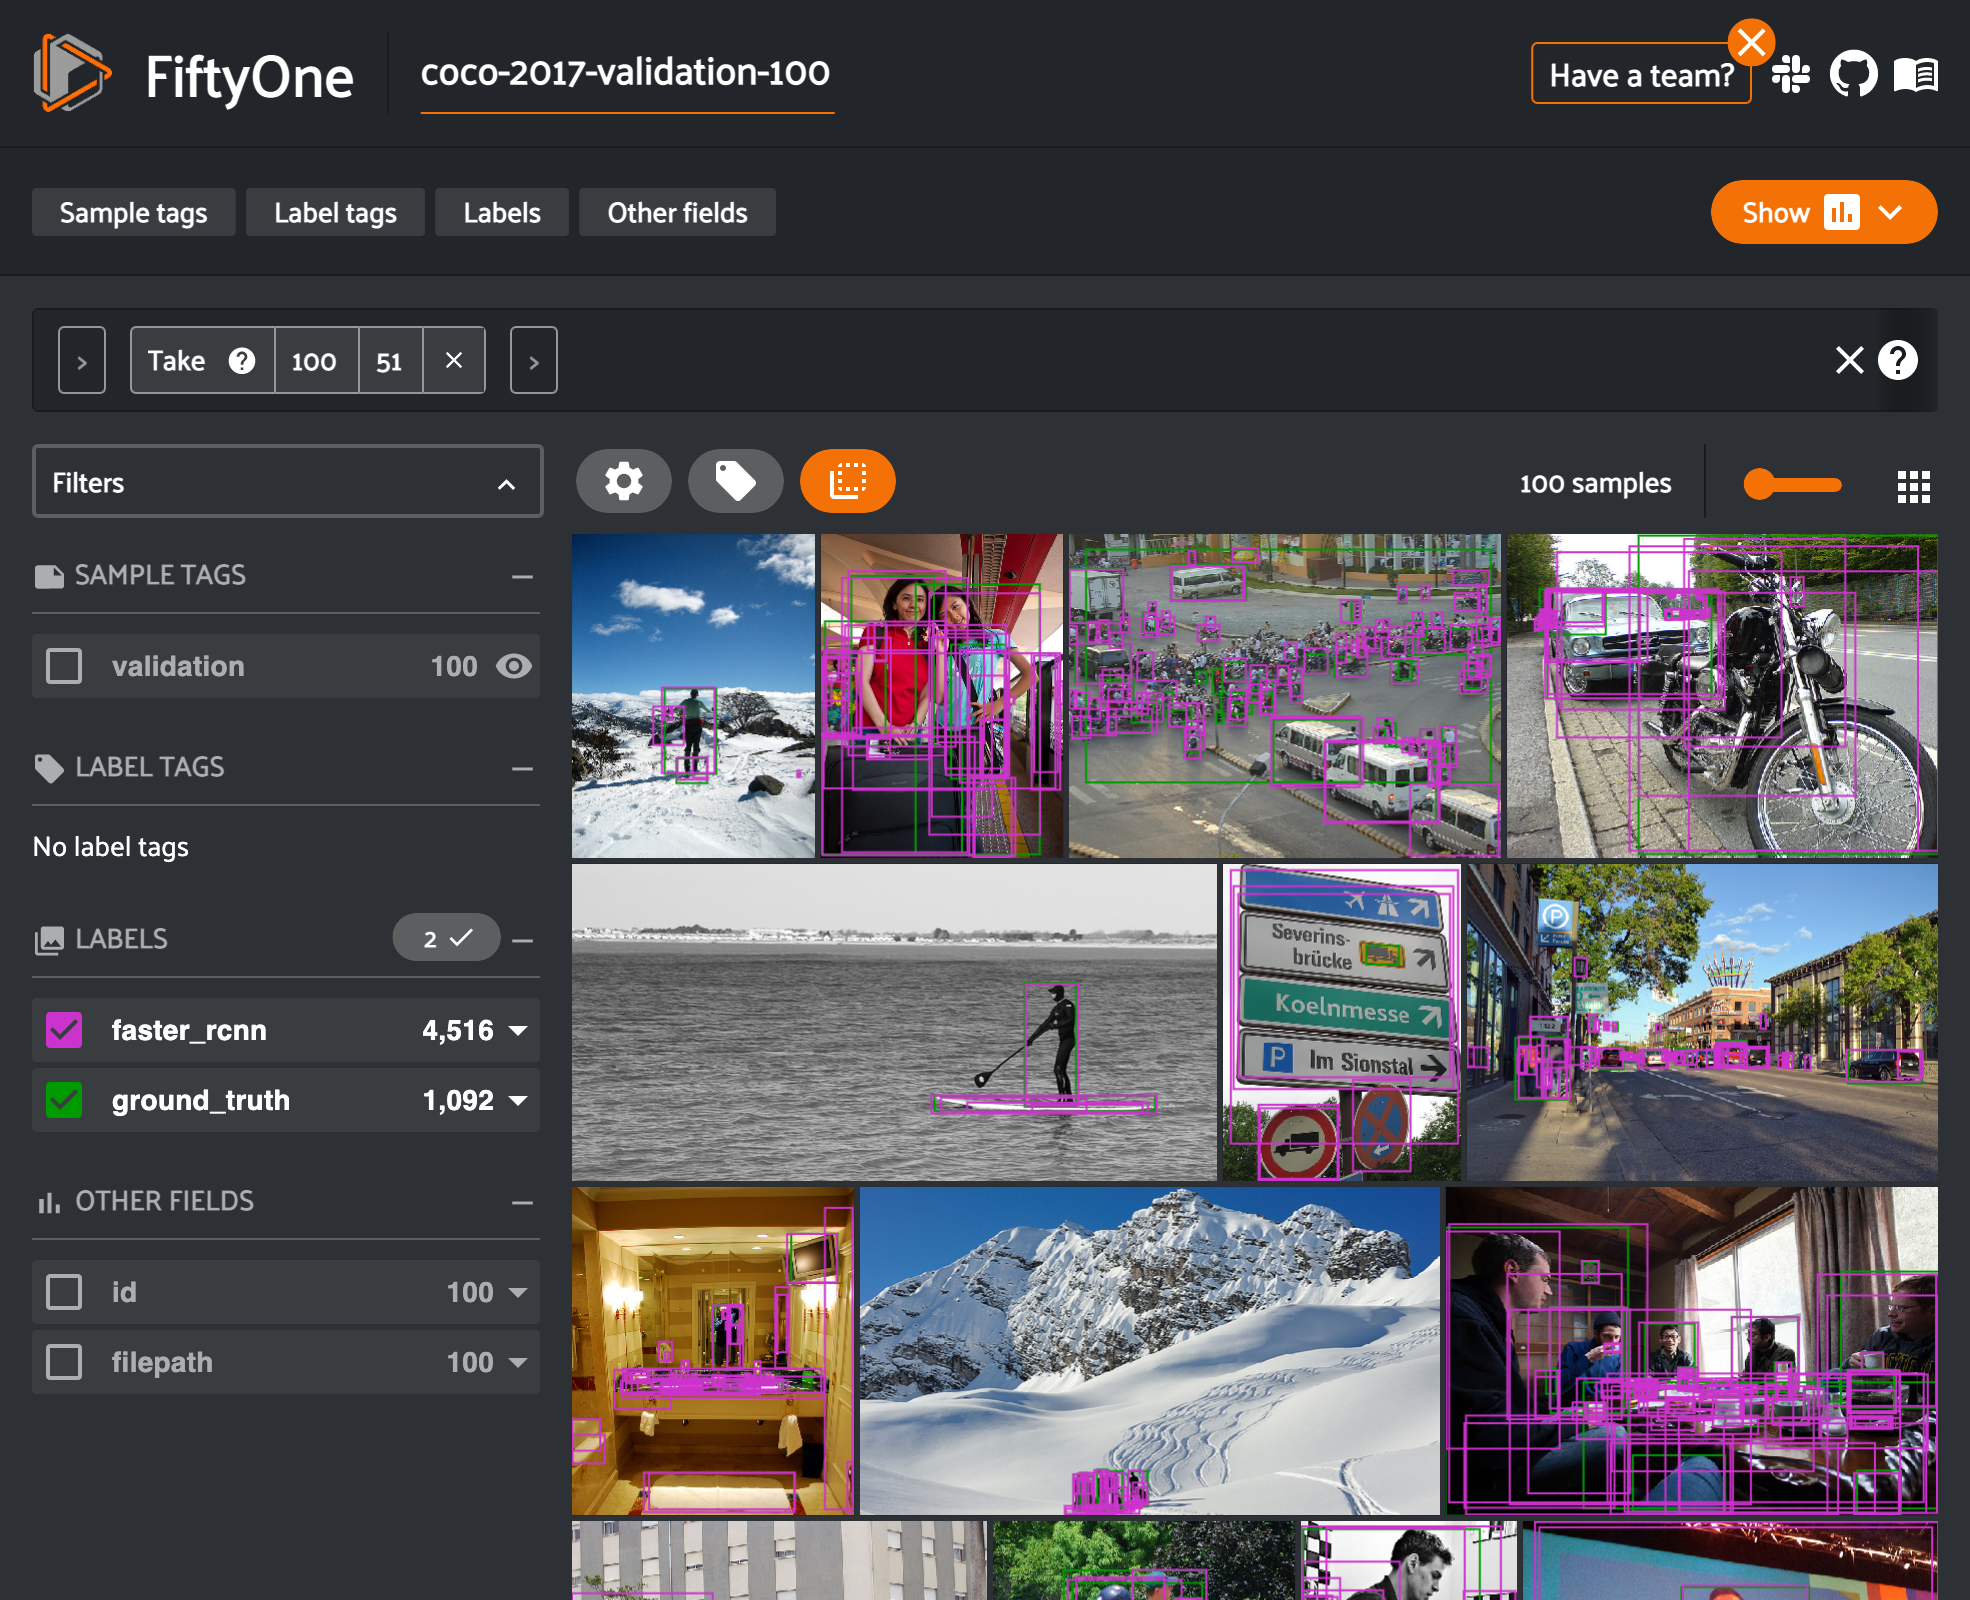

In [16]:
session = fo.launch_app(dataset)

In [8]:
predictions_view = dataset.take(100, seed=51)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
def inference(model, model_name):
    classes = dataset.default_classes
    with fo.ProgressBar() as pb:
        for sample in pb(predictions_view):
                # Load image
                image = Image.open(sample.filepath)
                image = func.to_tensor(image).to(device)
                c, h, w = image.shape

                # Perform inference
                preds = model([image])[0]
                labels = preds["labels"].cpu().detach().numpy()
                scores = preds["scores"].cpu().detach().numpy()
                boxes = preds["boxes"].cpu().detach().numpy()

                # Convert detections to FiftyOne format
                detections = []
                for label, score, box in zip(labels, scores, boxes):
                    # Convert to [top-left-x, top-left-y, width, height]
                    # in relative coordinates in [0, 1] x [0, 1]
                    x1, y1, x2, y2 = box
                    rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

                    detections.append(
                        fo.Detection(
                            label=classes[label],
                            bounding_box=rel_box,
                            confidence=score
                        )
                    )

                # Save predictions to dataset
                sample[model_name] = fo.Detections(detections=detections)
                sample.save()

In [25]:
retina_net = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
retina_net.to(device)
retina_net.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [27]:
fast_rccn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fast_rccn.to(device)
fast_rccn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [40]:
inference(retina_net, 'retinaNet')

 100% |█████████████████| 100/100 [20.0m elapsed, 0s remaining, 0.1 samples/s]    


In [42]:
inference(fast_rccn, 'fast_rccn')

 100% |█████████████████| 100/100 [18.4m elapsed, 0s remaining, 0.1 samples/s]    


In [43]:
session.view = predictions_view

In [50]:
fast_rcnn = high_conf_view.evaluate_detections(
    "fast_rccn",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)
retina_results = high_conf_view.evaluate_detections(
    "retinaNet",
    gt_field="ground_truth",
    eval_key="eval2",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████████| 96/96 [2.0s elapsed, 0s remaining, 46.6 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 96/96 [3.7s elapsed, 0s remaining, 29.3 samples/s]      
Evaluating detections...
 100% |███████████████████| 96/96 [6.5s elapsed, 0s remaining, 14.4 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 96/96 [11.8s elapsed, 0s remaining, 9.1 samples/s]      


In [55]:
fast_rcnn.mAP(), retina_results.mAP()

(0.4088856143043939, 0.3931866625775627)

In [84]:
result = yolo5(imgs)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [85]:
result.print()

image 1/100: 536x640 2 persons, 1 tie
image 2/100: 333x500 10 persons, 1 baseball bat, 1 baseball glove
image 3/100: 425x640 6 persons, 1 kite, 1 bottle, 3 cell phones
image 4/100: 426x640 2 persons, 1 banana
image 5/100: 480x640 3 persons, 2 buss
image 6/100: 640x427 1 person, 1 cell phone
image 7/100: 480x640 1 person, 1 elephant
image 8/100: 480x640 1 person, 1 car, 1 truck
image 9/100: 640x429 4 persons, 1 car, 1 skateboard
image 10/100: 315x640 1 person
image 11/100: 427x640 4 persons, 8 cars, 1 bus, 1 truck, 1 traffic light
image 12/100: 400x600 7 persons, 1 frisbee
image 13/100: 427x640 8 persons, 1 motorcycle
image 14/100: 480x640 7 cars, 1 truck
image 15/100: 427x640 4 persons, 2 boats, 1 bird, 1 handbag
image 16/100: 640x480 1 person, 6 cups, 3 forks, 3 knifes, 4 pizzas, 2 dining tables, 1 tv
image 17/100: 400x600 1 dog
image 18/100: 363x640 4 persons
image 19/100: 500x375 1 person, 5 cars, 1 motorcycle, 2 traffic lights
image 20/100: 427x640 5 persons, 2 bottles, 3 cups, 6 b

In [101]:
result.pandas().xyxy[1]

xmin        ymin        xmax        ymax  confidence  class  \
0    85.831734  187.170486  241.748383  324.165344    0.936624      0   
1    15.437663  141.656021  125.980438  323.507782    0.929952      0   
2   262.885345   75.820107  356.008911  298.378845    0.917347      0   
3    85.065285   71.721252  155.075012  140.546402    0.797981      0   
4   214.766342  231.252960  242.257767  264.566101    0.797158     35   
5   168.392929   74.186157  222.941254  133.316849    0.768229      0   
6    25.100548   98.302086   70.235039  147.506424    0.757558      0   
7   302.721924   26.705318  365.173035   93.391975    0.709562     34   
8   404.676270   58.822819  452.716827  114.268661    0.704425      0   
9   212.562057   71.884521  265.076233  131.477234    0.704197      0   
10   46.990974   82.193367   79.241310  133.123001    0.369155      0   
11    0.043517   92.295799   20.106279  149.876602    0.282928      0   

              name  
0           person  
1           person  
2           person  
3           person  
4   baseball glove  
5           person  
6           person  
7     baseball bat  
8           person  
9           person  
10          person  
11          person

In [89]:
result.xyxy[0]  # img1 predictions (tensor)
result.pandas().xyxy[0]  # img1 predictions (pandas)

xmin        ymin        xmax        ymax  confidence  class    name
0  256.072937   89.960770  626.645691  530.991089    0.898039      0  person
1   10.835419    0.000000  395.178009  536.000000    0.545175      0  person
2  195.934723  206.389465  252.925171  409.449341    0.499231     27     tie

In [90]:
yolo5

AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
           